In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import pairwise_distances  # This will make distance calculations very fast!


In [4]:
# Load the preprocessed dataset 
data = pd.read_csv(r"..\API\data\processed\train_data.csv")

# Separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

print("Data shape:", data.shape)
data.head()


Data shape: (25192, 11)


,service,flag,src_bytes,dst_bytes,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_serror_rate,class
0,-0.645371,0.753006,-0.009889,-0.039309,0.772093,-0.349275,-0.813968,-0.779141,-0.280668,-0.641791,1
1,0.768910,0.753006,-0.010032,-0.039309,-1.320540,0.490826,-1.030875,-1.157808,2.764349,-0.641791,1
2,1.090338,-0.739909,-0.010092,-0.039309,-1.388778,0.042772,-0.804931,-0.935063,-0.173825,1.603803,0
3,-0.452515,0.753006,-0.009996,0.052472,0.772093,-0.349275,1.264717,1.069642,-0.440932,-0.574424,1
4,-0.452515,0.753006,-0.010010,-0.034581,0.772093,-0.349275,1.264717,1.069642,-0.440932,-0.641791,1


In [5]:
# Define the KNN Classifier class with distance metrics and prediction methods
class KNNClassifier:
    def __init__(self, k=3, distance_metric="euclidean"):
        # Store k and distance metric choice
        self.k = k
        self.distance_metric = distance_metric

    def train(self, X_train, y_train):
        # Store training data for distance calculations
        self.X_train = X_train
        self.y_train = y_train

    def euclidean_distance(self, x1, x2):
        # Calculate Euclidean distance between two points
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def manhattan_distance(self, x1, x2):
        # Calculate Manhattan distance between two points
        return np.sum(np.abs(x1 - x2))

    def compute_distance(self, x1, x2):
        # Dynamically choose distance metric based on user choice
        if self.distance_metric == "euclidean":
            return self.euclidean_distance(x1, x2)
        elif self.distance_metric == "manhattan":
            return self.manhattan_distance(x1, x2)
        else:
            raise ValueError("Unsupported distance metric.")

    def predict_one(self, test_point):
        # Calculate distance from this test point to every training point
        distances = []
        for i in range(len(self.X_train)):
            dist = self.compute_distance(test_point, self.X_train[i])
            distances.append((dist, self.y_train[i]))

        # Sort distances and pick top k nearest points
        distances.sort(key=lambda x: x[0])
        top_k = distances[:self.k]

        # Perform majority voting
        labels = [label for _, label in top_k]
        prediction = max(set(labels), key=labels.count)
        return prediction

    def predict(self, X_test):
        # Predict class for each test point
        predictions = []
        for point in X_test:
            pred = self.predict_one(point)
            predictions.append(pred)
        return np.array(predictions)


In [6]:
class FastKNNClassifier:
    def __init__(self, k=3, distance_metric="euclidean"):
        self.k = k
        self.distance_metric = distance_metric

    def train(self, X_train, y_train):
        # Store training data
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        # Calculate all distances in one go using sklearn's pairwise_distances
        distances = pairwise_distances(X_test, self.X_train, metric=self.distance_metric)

        predictions = []
        # For each test point
        for dist in distances:
            # Get indices of k nearest neighbors
            nearest_indices = np.argsort(dist)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            # Majority vote
            prediction = np.bincount(nearest_labels.astype(int)).argmax()
            predictions.append(prediction)

        return np.array(predictions)


In [7]:
# Define a range of k values to test
k_values = list(range(1, 26, 2))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

k_accuracies = []

# Loop through k values
for k in k_values:
    fold_accuracies = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train Fast KNN
        knn = FastKNNClassifier(k=k, distance_metric="euclidean")
        knn.train(X_train, y_train)

        # Predict and evaluate
        preds = knn.predict(X_val)
        accuracy = np.mean(preds == y_val)
        fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    k_accuracies.append(avg_accuracy)

    print(f"K = {k}, Average 5-Fold Accuracy = {avg_accuracy:.4f}")


K = 1, Average 5-Fold Accuracy = 0.9856
K = 3, Average 5-Fold Accuracy = 0.9834
K = 5, Average 5-Fold Accuracy = 0.9817
K = 7, Average 5-Fold Accuracy = 0.9802
K = 9, Average 5-Fold Accuracy = 0.9787
K = 11, Average 5-Fold Accuracy = 0.9775
K = 13, Average 5-Fold Accuracy = 0.9763
K = 15, Average 5-Fold Accuracy = 0.9755
K = 17, Average 5-Fold Accuracy = 0.9741
K = 19, Average 5-Fold Accuracy = 0.9727
K = 21, Average 5-Fold Accuracy = 0.9716
K = 23, Average 5-Fold Accuracy = 0.9705
K = 25, Average 5-Fold Accuracy = 0.9693


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import numpy as np

def knn_predict(X_train, y_train, X_val, k=5, metric='euclidean'):
    distances = pairwise_distances(X_val, X_train, metric=metric)
    predictions = []
    for dist_row in distances:
        nearest_indices = np.argsort(dist_row)[:k]
        nearest_labels = y_train[nearest_indices]
        prediction = np.bincount(nearest_labels.astype(int)).argmax()
        predictions.append(prediction)
    return np.array(predictions)

def evaluate_knn_with_metric(X, y, k_values, metric):
    print(f"Evaluating for distance metric: {metric}")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for k in k_values:
        fold_accuracies = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            preds = knn_predict(X_train, y_train, X_val, k=k, metric=metric)
            acc = accuracy_score(y_val, preds)
            fold_accuracies.append(acc)
        
        print(f"K = {k}, {metric} distance, Average 5-Fold Accuracy = {np.mean(fold_accuracies):.4f}")
    print("\n")

# Example call (after loading your dataset):
k_values = [1, 3, 5, 7, 9]
evaluate_knn_with_metric(X, y, k_values, metric='euclidean')
evaluate_knn_with_metric(X, y, k_values, metric='manhattan')


Evaluating for distance metric: euclidean
K = 1, euclidean distance, Average 5-Fold Accuracy = 0.9856
K = 3, euclidean distance, Average 5-Fold Accuracy = 0.9834
K = 5, euclidean distance, Average 5-Fold Accuracy = 0.9817
K = 7, euclidean distance, Average 5-Fold Accuracy = 0.9802
K = 9, euclidean distance, Average 5-Fold Accuracy = 0.9787


Evaluating for distance metric: manhattan
K = 1, manhattan distance, Average 5-Fold Accuracy = 0.9866
K = 3, manhattan distance, Average 5-Fold Accuracy = 0.9852
K = 5, manhattan distance, Average 5-Fold Accuracy = 0.9840
K = 7, manhattan distance, Average 5-Fold Accuracy = 0.9834
K = 9, manhattan distance, Average 5-Fold Accuracy = 0.9825




In [ ]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Now, import your module
from API.model.knn_classifier import KNNClassifier  # Import your KNN classifier

print("Module imported successfully!")



✅ Module imported successfully!


In [ ]:
import joblib
import os

model_path = os.path.join("..", "API", "model", "saved_models", "knn_model.pkl")

# Try loading the model with joblib
try:
    knn_model = joblib.load(model_path)
    print("kNN Model Loaded Successfully!")
except Exception as e:
    print("Error:", e)


✅ kNN Model Loaded Successfully!


In [ ]:
# Load the test dataset
test_data_path = os.path.join("..", "API", "data", "processed", "test_data.csv")
df_test = pd.read_csv(test_data_path)

print("Test Data Loaded Successfully!")
print(df_test.head())  # Check the first few rows

✅ Test Data Loaded Successfully!
   service  flag  src_bytes  dst_bytes  logged_in  same_srv_rate  \
0       11     9         44        110          0           1.00   
1       22     9        176       5163          1           1.00   
2       22     9        223        338          1           1.00   
3       22     9        241        934          1           1.00   
4       65     5          0          0          0           0.03   

   diff_srv_rate  dst_host_srv_count  dst_host_same_srv_rate  \
0           0.00                 255                    1.00   
1           0.00                 245                    0.96   
2           0.00                 255                    1.00   
3           0.00                 255                    1.00   
4           0.05                   7                    0.03   

   dst_host_diff_srv_rate  class  
0                    0.00      1  
1                    0.01      1  
2                    0.00      1  
3                    0.00      1 

In [ ]:
X_test = df_test.iloc[:, :-1]  # All columns except last
y_test = df_test.iloc[:, -1]   # Last column (assumed to be labels)

print("✅ Test Data Ready! Features Shape:", X_test.shape, "Labels Shape:", y_test.shape)


✅ Test Data Ready! Features Shape: (5039, 10) Labels Shape: (5039,)


In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.9936

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2368
           1       1.00      0.99      0.99      2671

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039


🔹 Confusion Matrix:
[[2359    9]
 [  23 2648]]


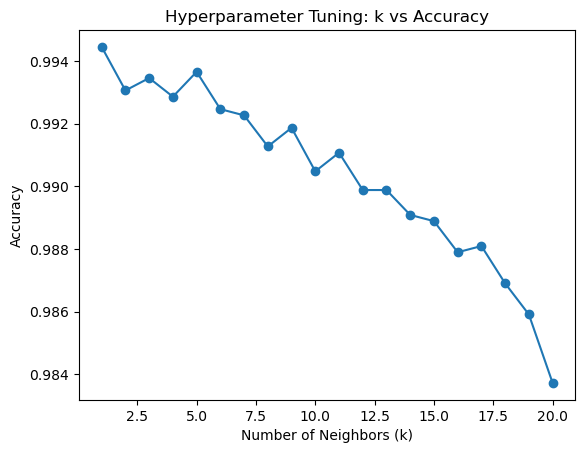

In [50]:
import matplotlib.pyplot as plt

# Try different values of k
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_model.k = k  # Change k value
    y_pred = knn_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Hyperparameter Tuning: k vs Accuracy")
plt.show()
